In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go

(a) Download the YouTube Spam Collection data set and turn it into dataframe

In [0]:
file_path = 'https://raw.githubusercontent.com/AliceWuno3/Discussion-for-2020/master/YouTube-Spam-Collection-v1/Youtube04-Eminem.csv'

In [0]:
df = pd.read_csv(file_path)

#### (b)divide the classes and set up train, test sets

In [0]:
# from sklearn.model_selection import train_test_split
# x_train, x_test,y_train, y_test=train_test_split(x, y, test_size=0.2)
H = df.loc[df['CLASS']==0]
S = df.loc[df['CLASS']==1]
tt_H=int(H.shape[0]*0.8)
tt_S=int(S.shape[0]*0.8)

In [0]:
x_train = pd.concat([H.iloc[0:tt_H,0:-1], S.iloc[0:tt_S:, 0:-1]], axis=0)
y_train = pd.concat([H.iloc[0:tt_H,-1], S.iloc[0:tt_S, -1]], axis=0)
x_test = pd.concat([H.iloc[tt_H:,0:-1], S.iloc[tt_S:, 0:-1]], axis=0)
y_test = pd.concat([H.iloc[tt_H:,-1], S.iloc[tt_S:, -1]], axis=0)

(c)represent it using TF-IDF features

In [0]:
# TF-IDF features for train data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=500)
tf_idf = vectorizer.fit_transform(x_train['CONTENT'])
tf_train = tf_idf.toarray()
tf_train.shape

(358, 500)

In [0]:
#TF-IDF features for test data

tf_idf = vectorizer.fit_transform(x_test['CONTENT'])
tf_test = tf_idf.toarray()


####**（d）For L2 penalty:**
(i)use five fold cross-validation to find the best lambda

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import math
lambda_list=np.arange(-5,6)
accur_list=[]
for i in lambda_list:
  c=math.pow(10,i)
  # for train and test in k folder
  logit = LogisticRegression(C=1/c, max_iter=100000)
  scores = cross_val_score(logit,tf_train,y_train,cv=5)
  accur=sum(scores)/5
  #add the average error of k folder
  accur_list.append(accur)


The accuracy of all the lambda from 10^(-5,...,5)

In [0]:
accur_list

[0.9050078247261346,
 0.9133802816901408,
 0.932981220657277,
 0.9301643192488263,
 0.9357589984350548,
 0.9385367762128325,
 0.86858372456964,
 0.5474960876369328,
 0.5474960876369328,
 0.5474960876369328,
 0.5474960876369328]

In [0]:
#find the best lambda
best_lam = math.pow(10,accur_list.index(max(accur_list))-5)

In [0]:
best_lam

1.0

(ii)Train l2 logistic on it

In [0]:
logit_model = LogisticRegression(C=best_lam).fit(tf_train,y_train)

Find the confusion matrixs... for training set 

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,roc_auc_score, roc_curve, auc

In [0]:
def evaluate_function(y_test, y_pred):
  print('confusion matrix:: \n', confusion_matrix(y_test, y_pred))
  print('accuracy::', accuracy_score(y_test, y_pred))
  print('precision::', precision_score(y_test, y_pred))
  print('recall::', recall_score(y_test, y_pred))
  print('f1 score::', f1_score(y_test, y_pred))
  print('AUC score::', roc_auc_score(y_test, y_pred))
  print()


def plot_roc(y_test, y_pred):
  fpr_test,tpr_test,threshold_test = roc_curve(y_test, y_pred) 
  roc_auc = auc(fpr_test,tpr_test) 


  plt.figure()
  lw = 2
  plt.figure(figsize=(12,8))
  plt.plot(fpr_test, tpr_test, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()

In [0]:
y_pred = logit_model.predict(tf_train)
evaluate_function(y_train, y_pred)

confusion matrix:: 
 [[162   0]
 [  7 189]]
accuracy:: 0.9804469273743017
precision:: 1.0
recall:: 0.9642857142857143
f1 score:: 0.9818181818181818
AUC score:: 0.9821428571428572



<Figure size 432x288 with 0 Axes>

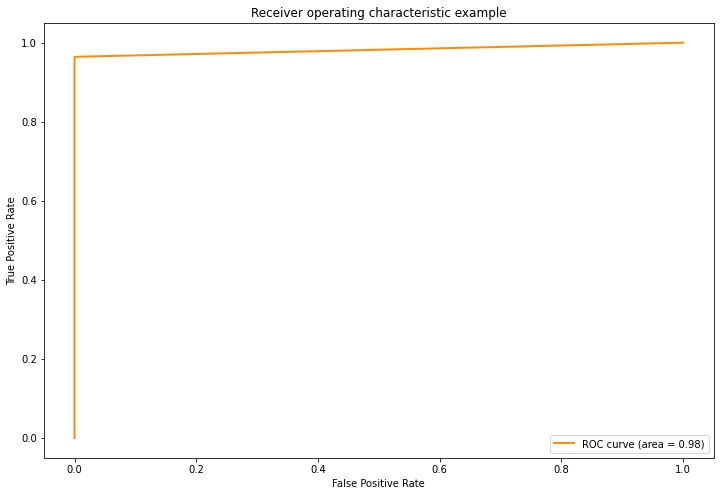

In [0]:
plot_roc(y_train, y_pred)

(iii)Find the confusion matrix... for test set


In [0]:
y_pred = logit_model.predict(tf_test)
evaluate_function(y_test, y_pred)

confusion matrix:: 
 [[38  3]
 [19 30]]
accuracy:: 0.7555555555555555
precision:: 0.9090909090909091
recall:: 0.6122448979591837
f1 score:: 0.7317073170731708
AUC score:: 0.7695370831259334



<Figure size 432x288 with 0 Axes>

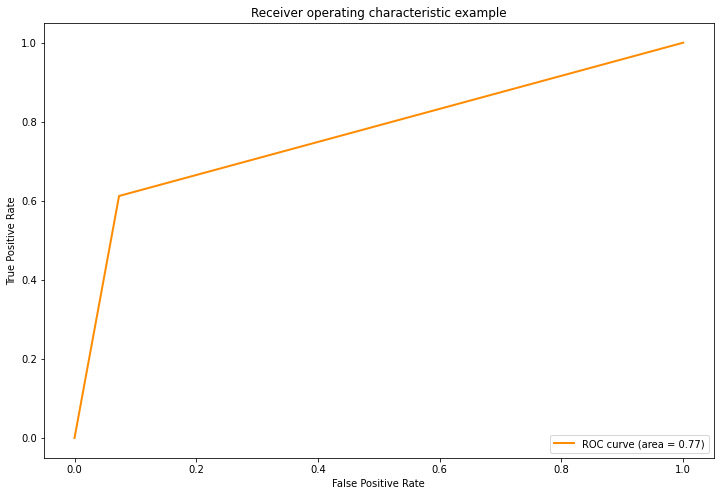

In [0]:
plot_roc(y_test, y_pred)

In [0]:
from sklearn.metrics import fbeta_score

In this application, precision is more important than recall, since we care more about to detect a potential spam message, and thus we don't care about the overall relevance of spam and ham in data, we want to just focus on whether our detection detects best.

In [0]:
beta_list = [0.1,0.5,0.9,1,5,10]
for b in beta_list:
  print("beta score with beta =", b, ":", fbeta_score(y_test,y_pred, b))

beta score with beta = 0.1 : 0.9047476858763811
beta score with beta = 0.5 : 0.8287292817679557
beta score with beta = 0.9 : 0.7470078415187783
beta score with beta = 1 : 0.7317073170731708
beta score with beta = 5 : 0.6200317965023848
beta score with beta = 10 : 0.6142306912629232


####**(e)For L1 penalty:**
(i)use five fold cross-validation to find the best lambda

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import math
lambda_list=np.arange(-5,6)
accur_list=[]
for i in lambda_list:
  c=math.pow(10,i)
  # for train and test in k folder
  logit = LogisticRegression(penalty= 'l1', solver='liblinear', C=1/c, max_iter=100000)
  scores = cross_val_score(logit,tf_train,y_train,cv=5)
  accur=sum(scores)/5
  #add the average error of k folder
  accur_list.append(accur)


In [0]:
accur_list

[0.8881064162754303,
 0.9216744913928012,
 0.9189749608763693,
 0.9217136150234742,
 0.9274256651017214,
 0.9050860719874805,
 0.5474960876369328,
 0.4525039123630673,
 0.4525039123630673,
 0.4525039123630673,
 0.4525039123630673]

In [0]:
best_lam = math.pow(10,accur_list.index(max(accur_list))-5)

In [0]:
best_lam

0.1

(ii)train logistic regression on it

In [0]:
logit_model = LogisticRegression(C=best_lam).fit(tf_train,y_train)

Find the confusion matrixs... for training set 

In [0]:
y_pred = logit_model.predict(tf_train)
evaluate_function(y_train, y_pred)

confusion matrix:: 
 [[141  21]
 [  3 193]]
accuracy:: 0.9329608938547486
precision:: 0.9018691588785047
recall:: 0.9846938775510204
f1 score:: 0.9414634146341464
AUC score:: 0.9275321239606953



<Figure size 432x288 with 0 Axes>

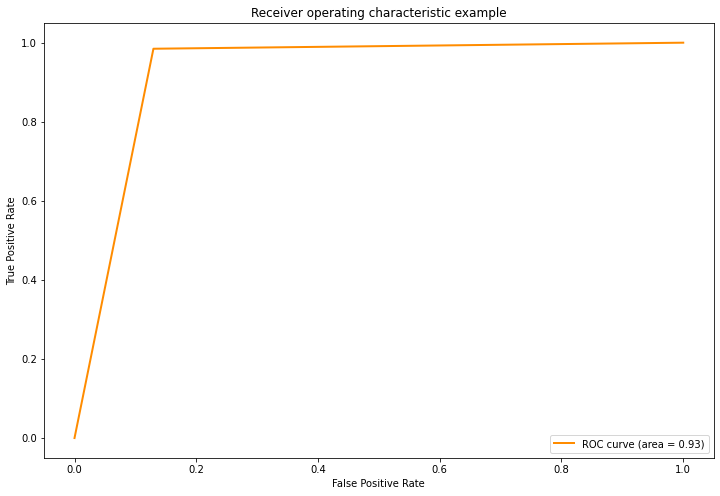

In [0]:
plot_roc(y_train, y_pred)

(iii)Find the confusion matrix... for test set


In [0]:
#confusion matrix
y_pred = logit_model.predict(tf_test)
evaluate_function(y_test, y_pred)

confusion matrix:: 
 [[28 13]
 [ 6 43]]
accuracy:: 0.7888888888888889
precision:: 0.7678571428571429
recall:: 0.8775510204081632
f1 score:: 0.819047619047619
AUC score:: 0.780238924838228



<Figure size 432x288 with 0 Axes>

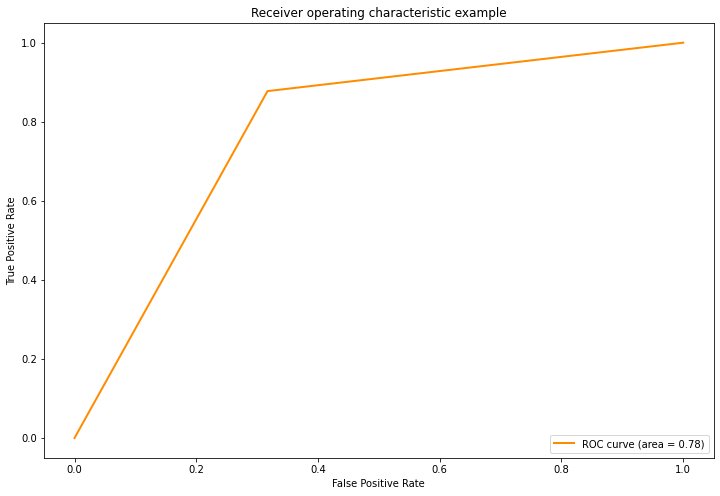

In [0]:
plot_roc(y_test, y_pred)

Binary Classification Using Naive Bayes' Classifiers

(f) using gaussian class conditional distribution

In [0]:
from sklearn.naive_bayes import GaussianNB
bayes_model=GaussianNB().fit(tf_train, y_train)
y_pred_train = bayes_model.predict(tf_train)
y_pred_test = bayes_model.predict(tf_test)

In [0]:
print('For training set:')
evaluate_function(y_train, y_pred_train)

For training set:
confusion matrix:: 
 [[162   0]
 [  5 191]]
accuracy:: 0.9860335195530726
precision:: 1.0
recall:: 0.9744897959183674
f1 score:: 0.9870801033591732
AUC score:: 0.9872448979591837



In [0]:
print('For test set:')
evaluate_function(y_test, y_pred_test)

For test set:
confusion matrix:: 
 [[11 30]
 [ 0 49]]
accuracy:: 0.6666666666666666
precision:: 0.620253164556962
recall:: 1.0
f1 score:: 0.765625
AUC score:: 0.6341463414634146



<Figure size 432x288 with 0 Axes>

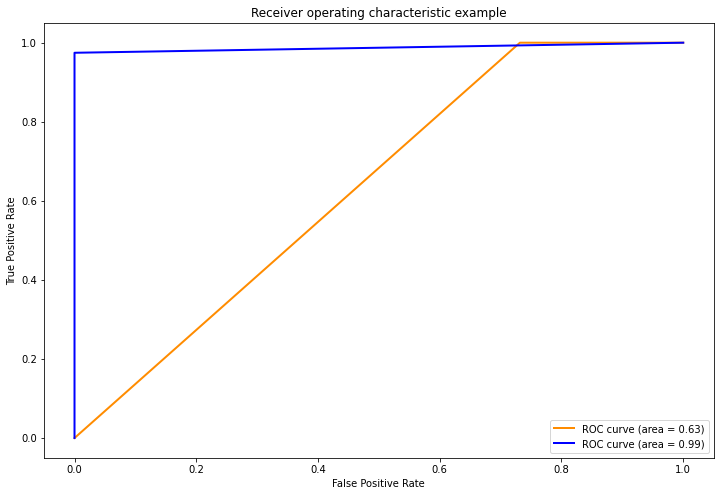

In [0]:

y_score_test=bayes_model.predict_proba(tf_test)
y_score_train=bayes_model.predict_proba(tf_train)
y_score_test=y_score_test[:,1]
y_score_train=y_score_train[:,1]

fpr_test,tpr_test,threshold_test = roc_curve(y_test, y_score_test) 
roc_auc_test = auc(fpr_test,tpr_test) 
fpr_train,tpr_train,threshold_train = roc_curve(y_train, y_score_train) 
roc_auc_train = auc(fpr_train,tpr_train) 

plt.figure()
lw = 2
plt.figure(figsize=(12,8))
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_test) 
plt.plot(fpr_train, tpr_train, color='blue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_train) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

(g)using multinomial priors

In [0]:
from sklearn.naive_bayes import MultinomialNB
bayes_model=MultinomialNB().fit(tf_train, y_train)
y_pred_train = bayes_model.predict(tf_train)
y_pred_test = bayes_model.predict(tf_test)

In [0]:
#confusion matrix for train
print('For training set:')
evaluate_function(y_train, y_pred_train)

For training set:
confusion matrix:: 
 [[151  11]
 [  6 190]]
accuracy:: 0.952513966480447
precision:: 0.945273631840796
recall:: 0.9693877551020408
f1 score:: 0.9571788413098237
AUC score:: 0.9507432602670698



In [0]:
print('For test set:')
evaluate_function(y_test, y_pred_test)

For test set:
confusion matrix:: 
 [[26 15]
 [18 31]]
accuracy:: 0.6333333333333333
precision:: 0.6739130434782609
recall:: 0.6326530612244898
f1 score:: 0.6526315789473685
AUC score:: 0.6333997013439522



<Figure size 432x288 with 0 Axes>

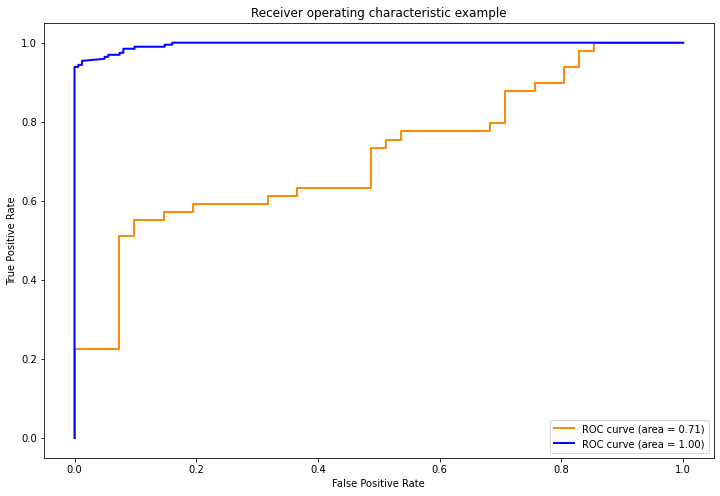

In [0]:
y_score_test=bayes_model.predict_proba(tf_test)
y_score_train=bayes_model.predict_proba(tf_train)
y_score_test=y_score_test[:,1]
y_score_train=y_score_train[:,1]

fpr_test,tpr_test,threshold_test = roc_curve(y_test, y_score_test) 
roc_auc_test = auc(fpr_test,tpr_test) 
fpr_train,tpr_train,threshold_train = roc_curve(y_train, y_score_train) 
roc_auc_train = auc(fpr_train,tpr_train) 

plt.figure()
lw = 2
plt.figure(figsize=(12,8))
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_test) 
plt.plot(fpr_train, tpr_train, color='blue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_train) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

###(h)

In [0]:
def best_lambda(model,tf_train, y_train, params):
    lambda_list=np.arange(-5,6)
    accur_list=[]
    for i in lambda_list:
      c=math.pow(10,i)
      # for train and test in k folder
      params.update({'C':1/c})
      test_model = model.set_params(**params)
      scores = cross_val_score(test_model,tf_train,y_train,cv=5)
      accur=sum(scores)/5
      #add the average error of k folder
      accur_list.append(accur)
    best_lam = math.pow(10,accur_list.index(max(accur_list))-5)
    return best_lam

In [0]:
import plotly.graph_objects as go

def generate_array(name,y_test, y_pred):
  
  array=[name, "%.2f" %accuracy_score(y_test, y_pred),"%.2f" %precision_score(y_test, y_pred),"%.2f" %recall_score(y_test, y_pred),\
         "%.2f" %f1_score(y_test, y_pred),"%.2f" %roc_auc_score(y_test, y_pred)]
  return array

In [0]:
def train_model(df,feature_num):
  H = df.loc[df['CLASS']==0]
  S = df.loc[df['CLASS']==1]
  tt_H=int(H.shape[0]*0.8)
  tt_S=int(S.shape[0]*0.8)
  x_train = pd.concat([H.iloc[0:tt_H,0:-1], S.iloc[0:tt_S:, 0:-1]], axis=0)
  y_train = pd.concat([H.iloc[0:tt_H,-1], S.iloc[0:tt_S, -1]], axis=0)
  x_test = pd.concat([H.iloc[tt_H:,0:-1], S.iloc[tt_S:, 0:-1]], axis=0)
  y_test = pd.concat([H.iloc[tt_H:,-1], S.iloc[tt_S:, -1]], axis=0)

  #extract tf-idf features from train and test
  vectorizer = TfidfVectorizer(max_features=feature_num)
  tf_idf = vectorizer.fit_transform(x_train['CONTENT'])
  tf_train = tf_idf.toarray()

  tf_idf = vectorizer.fit_transform(x_test['CONTENT'])
  tf_test = tf_idf.toarray()

  #For l2 penalty:
  model = LogisticRegression()
  params = {'max_iter':100000000}
  best_lam = best_lambda(model, tf_train, y_train, params)
  best_model = LogisticRegression(C=best_lam).fit(tf_train,y_train)
  y_pred=best_model.predict(tf_test)
  l2=generate_array('L2            ',y_test, y_pred)
  
  #For l1 penalty:
  model =  LogisticRegression()
  params = {'penalty': 'l1', 'solver':'liblinear','max_iter':pow(10,7)}
  best_lam = best_lambda(model, tf_train, y_train, params)
  best_model = LogisticRegression(C=best_lam).fit(tf_train,y_train)
  y_pred=best_model.predict(tf_test)
  l1=generate_array('L1            ',y_test, y_pred)

  #For GaussianNB:
  best_model = GaussianNB().fit(tf_train, y_train)
  y_pred=best_model.predict(tf_test)
  gaussian=generate_array('NB-Gaussian   ',y_test, y_pred)

  #For Multinomial
  best_model=MultinomialNB().fit(tf_train, y_train)
  y_pred=best_model.predict(tf_test)
  multinomial = generate_array('NB-Multinomial',y_test, y_pred)

  total = np.array([gaussian,multinomial,l2,l1])

  total = np.vstack((['Instances','Accuracy', 'Precision', 'Recall', 'F1', 'AUC'],total))

  # total = np.hstack(([['Instance'],['NB-Gaussian'],['NB-Multinomial'],['L2'],['L1']],total))

  # fig = go.Figure(data=[go.Table(header=dict(values=['Instances','Accuracy', 'Precision', 'Recall', 'F1', 'AUC']),
  #               cells=dict(values=total))])
  
  # fig.show()
  print (total)


In [414]:
file_path='https://raw.githubusercontent.com/AliceWuno3/Discussion-for-2020/master/YouTube-Spam-Collection-v1/Youtube01-Psy.csv'
df = pd.read_csv(file_path)
print('Psy:')
train_model(df,500)

Psy:
[['Instances' 'Accuracy' 'Precision' 'Recall' 'F1' 'AUC']
 ['NB-Gaussian   ' '0.50' '0.50' '0.71' '0.59' '0.50']
 ['NB-Multinomial' '0.43' '0.39' '0.26' '0.31' '0.43']
 ['L2            ' '0.47' '0.33' '0.06' '0.10' '0.47']
 ['L1            ' '0.47' '0.33' '0.06' '0.10' '0.47']]


In [415]:
file_path='https://raw.githubusercontent.com/AliceWuno3/Discussion-for-2020/master/YouTube-Spam-Collection-v1/Youtube02-KatyPerry.csv'
df = pd.read_csv(file_path)
print('KatePerry:')
train_model(df,500)

KatePerry:
[['Instances' 'Accuracy' 'Precision' 'Recall' 'F1' 'AUC']
 ['NB-Gaussian   ' '0.61' '0.57' '0.97' '0.72' '0.61']
 ['NB-Multinomial' '0.63' '0.60' '0.80' '0.68' '0.63']
 ['L2            ' '0.64' '0.68' '0.54' '0.60' '0.64']
 ['L1            ' '0.61' '0.57' '0.89' '0.70' '0.61']]


In [416]:
file_path='https://raw.githubusercontent.com/AliceWuno3/Discussion-for-2020/master/YouTube-Spam-Collection-v1/Youtube03-LMFAO.csv'
df = pd.read_csv(file_path)
print('LMFAO:')
train_model(df,364)

LMFAO:
[['Instances' 'Accuracy' 'Precision' 'Recall' 'F1' 'AUC']
 ['NB-Gaussian   ' '0.61' '0.60' '0.81' '0.69' '0.59']
 ['NB-Multinomial' '0.43' '0.43' '0.21' '0.28' '0.45']
 ['L2            ' '0.54' '0.54' '1.00' '0.70' '0.50']
 ['L1            ' '0.43' '0.00' '0.00' '0.00' '0.46']]


In [417]:
file_path='https://raw.githubusercontent.com/AliceWuno3/Discussion-for-2020/master/YouTube-Spam-Collection-v1/Youtube05-Shakira.csv'
df = pd.read_csv(file_path)
print('Shakira:')
train_model(df,341)

Shakira:
[['Instances' 'Accuracy' 'Precision' 'Recall' 'F1' 'AUC']
 ['NB-Gaussian   ' '0.57' '0.52' '1.00' '0.69' '0.60']
 ['NB-Multinomial' '0.59' '0.54' '0.86' '0.66' '0.60']
 ['L2            ' '0.87' '0.93' '0.77' '0.84' '0.86']
 ['L1            ' '0.53' '0.00' '0.00' '0.00' '0.50']]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

